In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


<a id="Libraries"></a>
# Libraries

In [2]:
#Import packages
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import time
import os

pd.set_option('display.float_format',lambda x: '%.4f' %x)
import seaborn as sns 
sns.set_context('paper',font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller

from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline


<a id="Read Data"></a>
# Read Data

In [3]:
# read dataset
df=pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt',delimiter=';')

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


<a id="Feature Engineering"></a>
# Feature Engineering

In [4]:
# Convert features for better analysis
df['date_time']=pd.to_datetime(df['Date']+' '+df['Time'])
df['Global_active_power']=pd.to_numeric(df['Global_active_power'],errors='coerce')
df=df.dropna(subset=['Global_active_power'])

df['date_time']=pd.to_datetime(df['date_time'])
df=df.loc[:,['date_time','Global_active_power']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)

In [5]:
df['year']=df['date_time'].apply(lambda x:x.year)
df['quarter']=df['date_time'].apply(lambda  x:x.quarter)
df['month']=df['date_time'].apply(lambda x:x.month)
df['day']=df['date_time'].apply(lambda x:x.day)
df=df.loc[:,['date_time','Global_active_power','year','quarter','month','day']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)
df['weekday']=df.apply(lambda row : row['date_time'].weekday(),axis=1)
df["weekday"]=(df['weekday']<5).astype(int)


print('Number of rows and columns after removing missing values:',df.shape)
print('The time series starts from:',df['date_time'].min())
print('The time series ends on:',df['date_time'].max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from: 2006-12-16 17:24:00
The time series ends on: 2010-12-11 23:59:00


In [6]:
# Check if data follows normal distribution or not
stat,p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.6f' %(stat,p))
alpha=0.05
if p>alpha :
  print('Data looks Gaussian(fail to reject H0)')
else:
  print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000000
Data does not look Gaussian (reject H0)


In [7]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 7 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date_time            datetime64[ns]
 1   Global_active_power  float64       
 2   year                 int64         
 3   quarter              int64         
 4   month                int64         
 5   day                  int64         
 6   weekday              int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 109.4 MB


,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0
5,2006-12-16 17:29:00,3.5200,2006,4,12,16,0
6,2006-12-16 17:30:00,3.7020,2006,4,12,16,0
7,2006-12-16 17:31:00,3.7000,2006,4,12,16,0
8,2006-12-16 17:32:00,3.6680,2006,4,12,16,0
9,2006-12-16 17:33:00,3.6620,2006,4,12,16,0


<a id="EDA"></a>
# EDA

Kurtosis of normal distribution: 4.218671866132123
Skewness of normal distribution: 1.7862320846320832


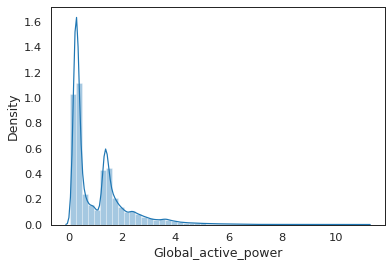

In [8]:
# check Kurtosis and skewness
sns.distplot(df.Global_active_power)
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print('Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

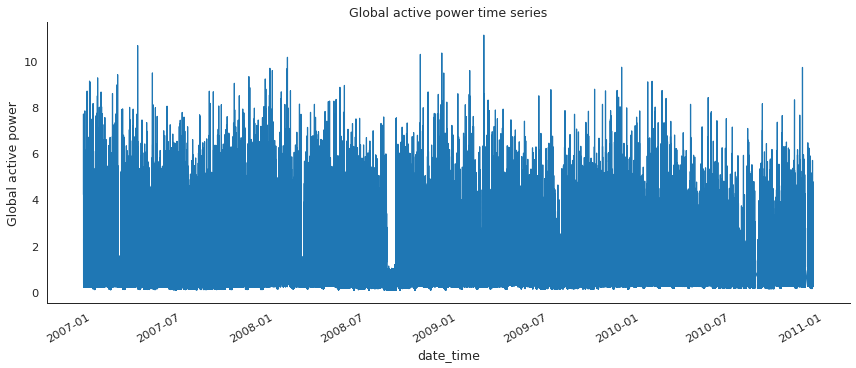

In [9]:
# Draw time series plot
df1=df.loc[:,['date_time' ,'Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global active power time series')
sns.despine(top=True)
plt.show()

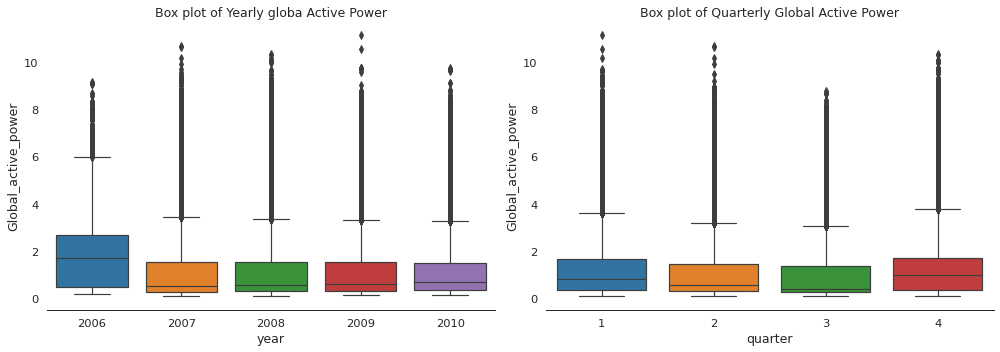

In [10]:
# Box plot of yearly vs quartly global active power
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x='year', y='Global_active_power',data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly globa Active Power')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x='quarter',y='Global_active_power',data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0000,1.0916,1.0573,0.0760,0.3080,0.6020,1.5280,11.1220


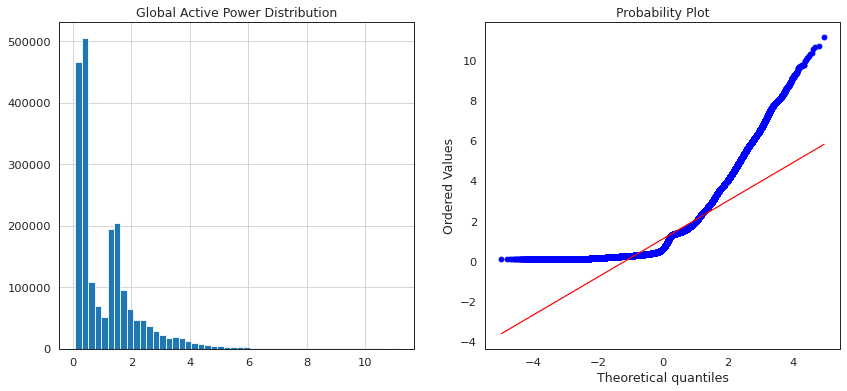

In [11]:
# Check the distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'],plot=plt)
df1.describe().T

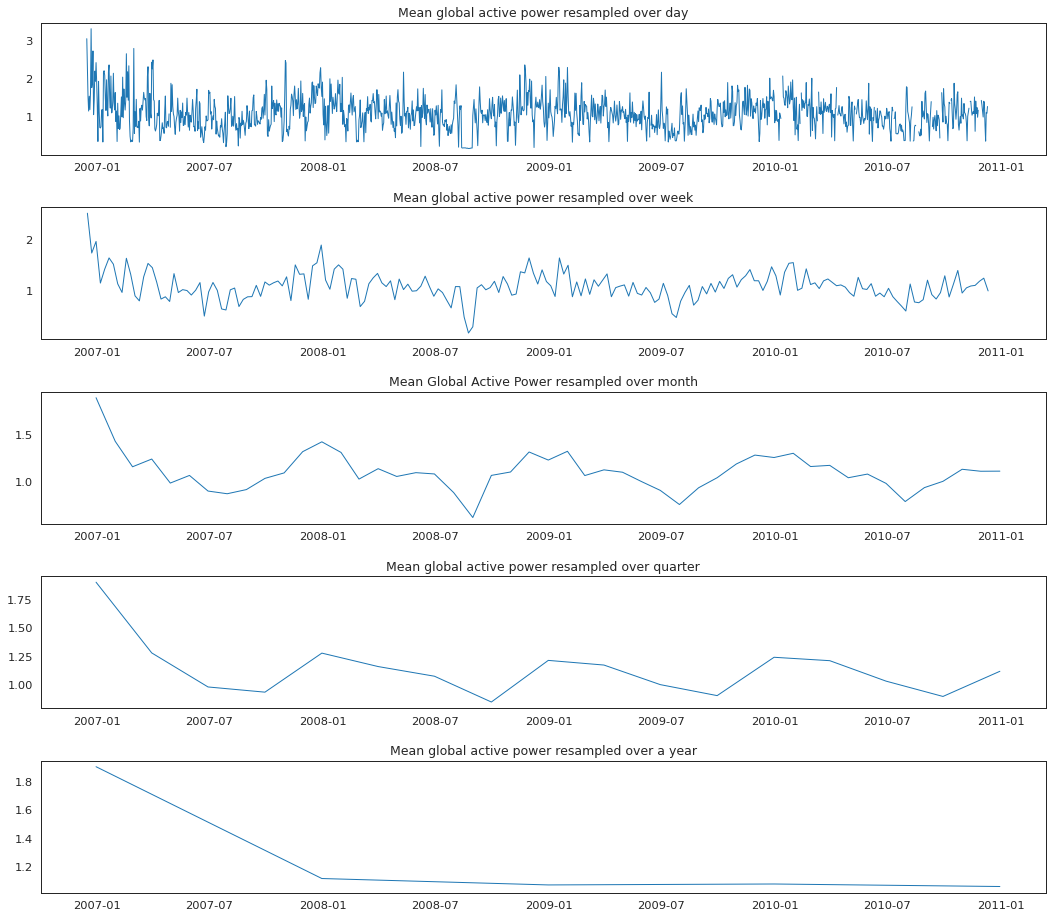

In [12]:
# Plot average global active power resampled over day,week,month quarter and year
fig=plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=0.4)
ax1=fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean global active power resampled over day')
ax1.tick_params(axis='both',which='major')

ax2=fig.add_subplot(5,1,2,sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean global active power resampled over week')
ax2.tick_params(axis='both',width='major')

ax3=fig.add_subplot(5,1,3,sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title("Mean Global Active Power resampled over month")
ax3.tick_params(axis='both',which='major')

ax4=fig.add_subplot(5,1,4,sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean global active power resampled over quarter')
ax4.tick_params(axis='both',which='major')

ax5=fig.add_subplot(5,1,5,sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean global active power resampled over a year')
ax5.tick_params(axis='both',which='major')

######The time series has no upward or downward trend. The highest average power consumption seems to be prior to 2007 and thats because we only have december data for 2007. December is winter month and its expected to have power consumption increased.

Text(0.5, 1.0, 'Mean global active power by day')

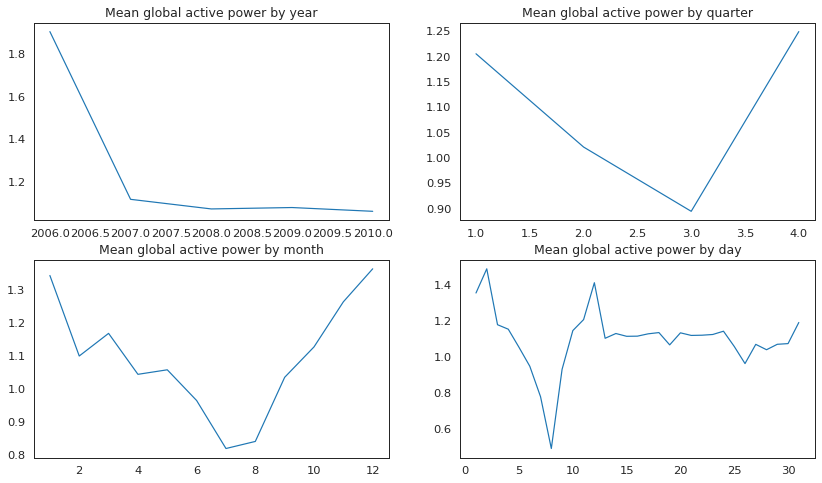

In [13]:
# Plot mean global active power grouped by year, quarter,monh and day

plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by day')

By year , power is steady after 2007
by month , power is lowest in 7th month
by day power is lowest on 8th of every month
by quarter, its lowest on 3rd quarter

array([[<AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
        <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
        <AxesSubplot:xlabel='month'>],
       [<AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
        <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
        <AxesSubplot:xlabel='month'>],
       [<AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
        <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
        <AxesSubplot:xlabel='month'>]], dtype=object)

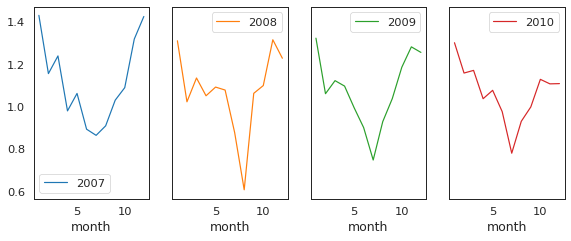

In [14]:
#We remove 2006 because other years have similar pattern.
pd.pivot_table(df.loc[df['year']!=2006],values='Global_active_power',columns='year',index='month').plot(subplots=True,figsize=(12,12),layout=(3,5),sharey=True)

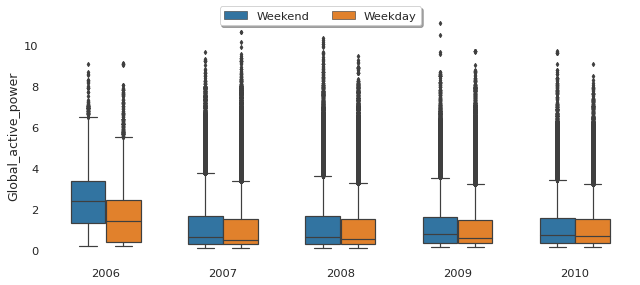

In [15]:
# Check power consumption during weekdays and weekends

dic={0:'Weekend',1:'Weekday'}
df['Day']=df.weekday.map(dic)

a=plt.figure(figsize=(9,4))
plt1=sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,data=df)
a.legend(loc='upper center',bbox_to_anchor=(0.5,1.0),shadow=True,ncol=2)

sns.despine(left=True,bottom=True)
plt.xlabel('')
plt.tight_layout()
plt.legend().set_visible(False)

In [16]:
df.head()

,date_time,Global_active_power,year,quarter,month,day,weekday,Day
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0,Weekend
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0,Weekend
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0,Weekend
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0,Weekend
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0,Weekend


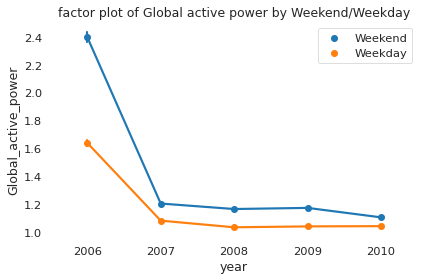

In [17]:
# Factor plot of global active power by weekday vs weekend
plt1=sns.factorplot('year','Global_active_power',hue='Day',data=df, size=4,aspect=1.5,legend=False)
plt.title('factor plot of Global active power by Weekend/Weekday')
plt.tight_layout()
sns.despine(left=True,bottom=True)
plt.legend(loc='upper right')

#####Check if data is stationary or not
use Dickey-Fuller test

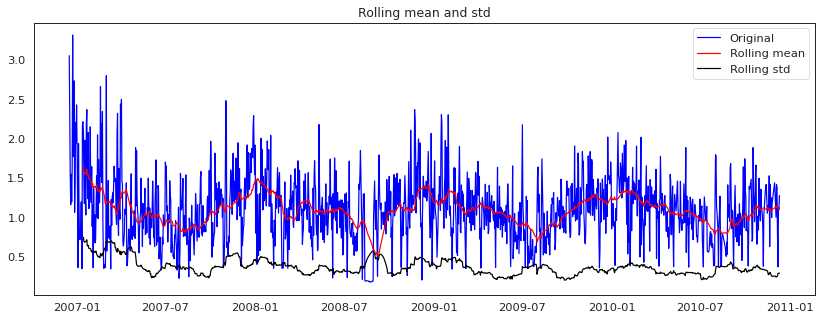

<Results of Dickey Fuller Test>
Test stastic                    -8.3277
p-value                          0.0000
#Lags Used                       9.0000
Number of observations used   1423.0000
Critical Value (1%)             -3.4350
Critical Value (5%)             -2.8636
Critical Value (10%)            -2.5679
dtype: float64


In [18]:
df2=df1.resample('D').mean()

def test_stationarity(timeseries):
  rolmean=timeseries.rolling(window=30).mean()
  rolstd=timeseries.rolling(window=30).std()

  plt.figure(figsize=(14,5))
  sns.despine(left=True)
  orig=plt.plot(timeseries,color='blue',label='Original')
  mean=plt.plot(rolmean,color='red',label='Rolling mean')
  std=plt.plot(rolstd, color='black',label='Rolling std')

  plt.legend(loc='best')
  plt.title('Rolling mean and std')
  plt.show()

  print('<Results of Dickey Fuller Test>')
  dftest=adfuller(timeseries,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],
                     index=['Test stastic','p-value','#Lags Used','Number of observations used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key]=value
  print(dfoutput)

test_stationarity(df2.Global_active_power.dropna())

<a id="MODELING+LSTM"></a>
# MODELING+LSTM

In [19]:
# Use LSTM model to predict
# Convert all data to float
# Normalize the featue
# Convert array into matrix
# Reshape into x=t and y=t+1
# reshape input to be 3D(samples, timesteps, features)

dataset=df.Global_active_power.values
dataset=dataset.astype('float32')
dataset=np.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)
train_size=int(len(dataset)*0.8)
test_size=len(dataset)-train_size
train,test =dataset[0:train_size,:],dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
  x,y=[],[]
  for i in range(len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    x.append(a)
    y.append(dataset[i+look_back,0])
  return np.array(x),np.array(y)

look_back=30

x_train,y_train=create_dataset(train,look_back)
x_test,y_test=create_dataset(test,look_back)

# Reshape inputs 
x_train= np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test=np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))

In [20]:
# Train the model
model=tf.keras.Sequential()
model.add(LSTM(100,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history=model.fit(x_train,y_train, epochs=20, batch_size=70,validation_data=(x_test,y_test),
                  callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=1,shuffle=False)
model.summary()

2022-12-11 00:07:59.844249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 00:08:00.007348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 00:08:00.008496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 00:08:00.010318: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20


2022-12-11 00:08:05.973466: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


23420/23420 [==============================] - 96s 4ms/step - loss: 8.0887e-04 - val_loss: 4.4753e-04
Epoch 2/20
23420/23420 [==============================] - 92s 4ms/step - loss: 6.7216e-04 - val_loss: 4.2989e-04
Epoch 3/20
23420/23420 [==============================] - 93s 4ms/step - loss: 6.5450e-04 - val_loss: 4.3629e-04
Epoch 4/20
23420/23420 [==============================] - 92s 4ms/step - loss: 6.4617e-04 - val_loss: 4.2365e-04
Epoch 5/20
23420/23420 [==============================] - 91s 4ms/step - loss: 6.4308e-04 - val_loss: 4.3212e-04
Epoch 6/20
23420/23420 [==============================] - 92s 4ms/step - loss: 6.4183e-04 - val_loss: 4.2885e-04
Epoch 7/20
23420/23420 [==============================] - 91s 4ms/step - loss: 6.3667e-04 - val_loss: 4.1606e-04
Epoch 8/20
23420/23420 [==============================] - 92s 4ms/step - loss: 6.4039e-04 - val_loss: 4.1938e-04
Epoch 9/20
23420/23420 [==============================] - 91s 4ms/step - loss: 6.3493e-04 - val_loss: 4.170

<a id="PEDICTION"></a>
# PREDICTION

In [21]:
#Make predictions

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.11013857467502056
Train Root Mean Squared Error: 0.26831697768446733
Test Mean Absolute Error: 0.09695681724327763
Test Root Mean Squared Error: 0.2232077065847867


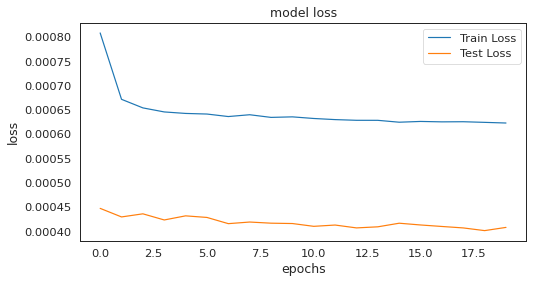

In [22]:
#plot model losses
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

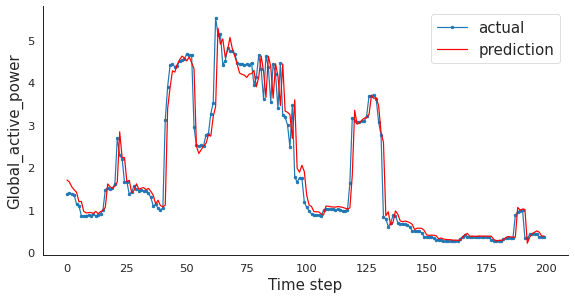

In [24]:
#Compare actual vs predicted for last 200 minutes

aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

<a id="Reference"></a>
##### Reference https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba..

<a id="Continue"></a>
##### Continue- Hyperparameter tuning with OPTUNA..